<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/QUANT008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 首先安装TA-Lib系统依赖
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!make install
%cd ..

# 安装Python TA-Lib包
!pip install TA-Lib

# 安装其他必要的包
!pip install yfinance pandas numpy matplotlib

# 现在可以导入所需的库
import yfinance as yf
import pandas as pd
import numpy as np
import talib
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

--2024-11-28 18:46:41--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-11-28 18:46:41--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:c95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://deac-riga.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-11-28 18:46:41--  http://deac-riga.dl.so

In [2]:
!apt-get update
!apt-get install -y fonts-wqy-zenhei

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 388 kB in 2s (239 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
R

In [3]:
!pip install mplfinance

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import mplfinance as mpf

def format_hk_stock_code(symbol):
    symbol = symbol.replace('.HK', '')
    symbol = symbol.zfill(4)
    return f"{symbol}.HK"

def get_stock_data(symbol, start_date, end_date):
    symbol = format_hk_stock_code(symbol)
    print(f"Downloading data for {symbol}...")

    try:
        stock = yf.download(symbol, start=start_date, end=end_date, interval='1d')

        if stock.empty:
            print(f"No data available for {symbol}")
            return None

        df = stock.copy()

        # Calculate VWAP
        df['VWAP'] = df.apply(lambda x: (x['High'] + x['Low'] + x['Close']) / 3, axis=1)

        # Calculate MA5
        df['MA5'] = df['Close'].rolling(window=5).mean()

        # Calculate Change Ratio
        df['Change_Ratio'] = df['Close'].pct_change() * 100

        # Calculate Turnover Rate
        df['Turnover_Rate'] = (df['Volume'] / df['Volume'].mean()) * 100

        # Calculate MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

        # Calculate KDJ
        low_min = df['Low'].rolling(window=9).min()
        high_max = df['High'].rolling(window=9).max()
        rsv = 100 * ((df['Close'] - low_min) / (high_max - low_min))
        df['K'] = rsv.ewm(com=2, adjust=False).mean()
        df['D'] = df['K'].ewm(com=2, adjust=False).mean()
        df['J'] = 3 * df['K'] - 2 * df['D']

        # Calculate EMV
        dm = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
        br = (df['Volume'] / 100000000) / ((df['High'] - df['Low']))
        emv = dm / br
        df['EMV'] = emv.rolling(14).mean()

        # Calculate RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        return df

    except Exception as e:
        print(f"Error occurred: {e}")
        return None

# Test code
symbol = '1860'
start_date = '2024-09-20'
end_date = '2024-11-28'

df = get_stock_data(symbol, start_date, end_date)



[*********************100%***********************]  1 of 1 completed



Stock Statistics:
Latest Close: 8.41
VWAP: 8.57
MA5: 8.50
MACD: 1.74
KDJ (K/D/J): 75.83/79.42/68.66
Change Ratio: 2.44%
Turnover Rate: 156.02%


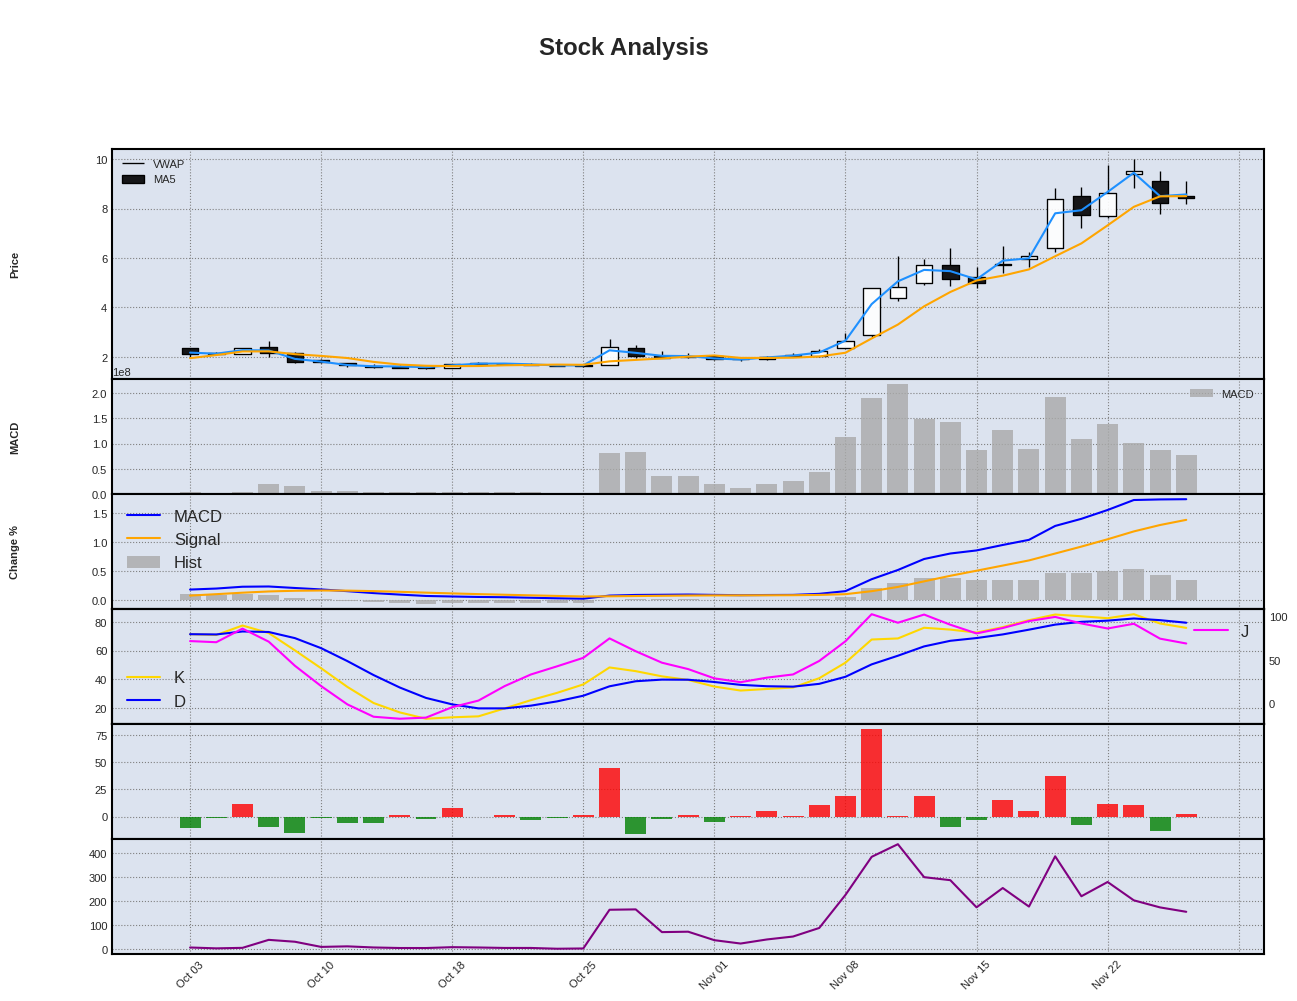

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import mplfinance as mpf

if df is not None:
    # 创建新的DataFrame
    df_plot = pd.DataFrame({
        'Open': df[('Open', '1860.HK')],
        'High': df[('High', '1860.HK')],
        'Low': df[('Low', '1860.HK')],
        'Close': df[('Close', '1860.HK')],
        'Volume': df[('Volume', '1860.HK')],
        'VWAP': df[('VWAP', '')],
        'MA5': df[('MA5', '')],
        'Change_Ratio': df[('Change_Ratio', '')],
        'Turnover_Rate': df[('Turnover_Rate', '')]
    })

    # 添加技术指标
    df_plot['MACD'] = df[('MACD', '')]
    df_plot['MACD_Signal'] = df[('MACD_Signal', '')]
    df_plot['MACD_Hist'] = df[('MACD_Hist', '')]
    df_plot['K'] = df[('K', '')]
    df_plot['D'] = df[('D', '')]
    df_plot['J'] = df[('J', '')]

    # 删除包含NaN的行
    df_plot = df_plot.dropna()

    # 设置颜色
    vwap_color = 'dodgerblue'
    ma5_color = 'orange'

    # 添加自定义指标
    add_plot = [
        # Panel 0 (主图)
        mpf.make_addplot(df_plot['VWAP'], panel=0, color=vwap_color, label='VWAP', width=1.5),
        mpf.make_addplot(df_plot['MA5'], panel=0, color=ma5_color, label='MA5', width=1.5),

        # Panel 1 (成交量)
        mpf.make_addplot(df_plot['Volume'], panel=1, type='bar', color='darkgray', alpha=0.8, label='Volume'),

        # Panel 2 (MACD)
        mpf.make_addplot(df_plot['MACD'], panel=2, color='blue', label='MACD', width=1.5),
        mpf.make_addplot(df_plot['MACD_Signal'], panel=2, color='orange', label='Signal', width=1.5),
        mpf.make_addplot(df_plot['MACD_Hist'], panel=2, type='bar', color='darkgray', label='Hist', alpha=0.8),

        # Panel 3 (KDJ)
        mpf.make_addplot(df_plot['K'], panel=3, color='gold', label='K', width=1.5),
        mpf.make_addplot(df_plot['D'], panel=3, color='blue', label='D', width=1.5),
        mpf.make_addplot(df_plot['J'], panel=3, color='magenta', label='J', width=1.5),

        # Panel 4 (涨跌幅)
        mpf.make_addplot(df_plot['Change_Ratio'], panel=4, type='bar',
                        color=['red' if x >= 0 else 'green' for x in df_plot['Change_Ratio']], alpha=0.8),

        # Panel 5 (换手率)
        mpf.make_addplot(df_plot['Turnover_Rate'], panel=5, color='purple', width=1.5)
    ]

    # 优化样式设置
    style = mpf.make_mpf_style(
        base_mpf_style='default',  # 使用charles风格，更清晰
        gridstyle=':',
        gridcolor='gray',
        rc={
            'figure.figsize': (20, 12),  # 调整整体图表大小
            'axes.labelsize': 10,
            'axes.titlesize': 12,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8
        }
    )

    # 创建子图，调整比例
    fig, axes = mpf.plot(
        df_plot,
        type='candle',
        style=style,
        volume=False,
        addplot=add_plot,
        panel_ratios=(4, 2, 2, 2, 2, 2),  # 调整主图与副图的比例
        title='\nStock Analysis',
        ylabel='Price',
        returnfig=True,
        figscale=2,  # 增加整体尺寸
        tight_layout=False,  # 关闭自动布局以便手动调整
        ylabel_lower='Volume'
    )

    # 添加图例并优化位置
    axes[0].legend(['VWAP', 'MA5'], loc='upper left', fontsize=8)
    # 注意：mplfinance处理Volume时候 有种特殊处理机制
    #axes[1].legend(['Volume'], loc='upper left', fontsize=8)  # 添加成交量图例
    # 手动创建Volume图例
    volume_line = plt.Line2D([0], [0], color='darkgray', label='Volume', marker='s', linestyle='None',
                            markersize=10, alpha=0.8)
    axes[1].legend(handles=[volume_line], loc='upper left', fontsize=8)
    axes[2].legend(['MACD', 'Signal', 'Hist'], loc='upper right', fontsize=8)
    axes[3].legend(['K', 'D', 'J'], loc='upper left', fontsize=8)


    # 调整主图价格标签位置
    axes[0].yaxis.set_label_coords(-0.1, 0.5)

    # 调整整体布局 - 需要先调整布局再设置标签位置
    plt.subplots_adjust(
        left=0.15,    # 增加左边距，为标签留出更多空间
        right=0.95,   # 右边距
        top=0.95,     # 上边距
        bottom=0.05,  # 下边距
        hspace=0.0    # 减小子图间距
    )

    # 统一调整所有y轴标签位置
    label_x = -0.08  # 统一的x轴位置

    # 设置主图标签位置
    axes[0].set_ylabel('Price', fontsize=8)
    axes[0].yaxis.set_label_coords(label_x, 0.5)

    # 设置其他子图标签位置
    for i, (ax, label) in enumerate(zip(
        axes[1:],
        ['Volume', 'MACD', 'KDJ', 'Change %', 'Turnover %']
    )):
        ax.set_ylabel(label, fontsize=8)
        ax.yaxis.set_label_coords(label_x, 0.5)  # 调整标签位置，第一个参数控制左右，第二个参数控制上下

    ## 调整子图间距
    #plt.subplots_adjust(hspace=0.5)

    # 显示统计信息
    print("\nStock Statistics:")
    print("=" * 100)
    latest = df_plot.iloc[-1]
    print(f"Latest Close: {latest['Close']:.2f}")
    print(f"VWAP: {latest['VWAP']:.2f}")
    print(f"MA5: {latest['MA5']:.2f}")
    print(f"MACD: {latest['MACD']:.2f}")
    print(f"KDJ (K/D/J): {latest['K']:.2f}/{latest['D']:.2f}/{latest['J']:.2f}")
    print(f"Change Ratio: {latest['Change_Ratio']:.2f}%")
    print(f"Turnover Rate: {latest['Turnover_Rate']:.2f}%")

    plt.show()

In [6]:
!pip install plotly

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if df is not None:
    # 创建子图布局
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.4, 0.15, 0.15, 0.1, 0.1, 0.1],
        subplot_titles=('K线图 - VWAP & MA5', '成交量', 'MACD', 'KDJ', '涨跌幅', '换手率')
    )

    # 添加K线图
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df[('Open', '1860.HK')],
            high=df[('High', '1860.HK')],
            low=df[('Low', '1860.HK')],
            close=df[('Close', '1860.HK')],
            name='K线'
        ),
        row=1, col=1
    )

    # 添加VWAP和MA5
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('VWAP', '')],
            name='VWAP',
            line=dict(color='dodgerblue')
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('MA5', '')],
            name='MA5',
            line=dict(color='orange')
        ),
        row=1, col=1
    )

    # 添加成交量
    colors = ['red' if row[('Close', '1860.HK')] >= row[('Open', '1860.HK')] else 'green'
              for i, row in df.iterrows()]

    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df[('Volume', '1860.HK')],
            name='成交量',
            marker_color=colors
        ),
        row=2, col=1
    )

    # 添加MACD
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('MACD', '')],
            name='MACD',
            line=dict(color='blue')
        ),
        row=3, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('MACD_Signal', '')],
            name='Signal',
            line=dict(color='orange')
        ),
        row=3, col=1
    )

    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df[('MACD_Hist', '')],
            name='MACD Hist',
            marker_color='gray'
        ),
        row=3, col=1
    )

    # 添加KDJ
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('K', '')],
            name='K',
            line=dict(color='gold')
        ),
        row=4, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('D', '')],
            name='D',
            line=dict(color='blue')
        ),
        row=4, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('J', '')],
            name='J',
            line=dict(color='magenta')
        ),
        row=4, col=1
    )

    # 添加涨跌幅
    colors = ['red' if x >= 0 else 'green' for x in df[('Change_Ratio', '')]]
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df[('Change_Ratio', '')],
            name='涨跌幅',
            marker_color=colors
        ),
        row=5, col=1
    )

    # 添加换手率
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('Turnover_Rate', '')],
            name='换手率',
            line=dict(color='purple')
        ),
        row=6, col=1
    )

    # 更新布局
    fig.update_layout(
        title='Stock Analysis',
        height=1200,  # 总高度
        width=1500,   # 总宽度
        showlegend=True,
        xaxis_rangeslider_visible=False,  # 禁用底部的范围滑块
        template='plotly_white',  # 使用白色主题
    )

    # 更新y轴标签
    fig.update_yaxes(title_text="价格", row=1, col=1)
    fig.update_yaxes(title_text="成交量", row=2, col=1)
    fig.update_yaxes(title_text="MACD", row=3, col=1)
    fig.update_yaxes(title_text="KDJ", row=4, col=1)
    fig.update_yaxes(title_text="涨跌幅(%)", row=5, col=1)
    fig.update_yaxes(title_text="换手率(%)", row=6, col=1)

    # 显示图表
    fig.show()

    # 打印统计信息
    print("\nStock Statistics:")
    print("=" * 100)
    latest = df.iloc[-1]
    print(f"Latest Close: {latest[('Close', '1860.HK')]:.2f}")
    print(f"VWAP: {latest[('VWAP', '')]:.2f}")
    print(f"MA5: {latest[('MA5', '')]:.2f}")
    print(f"MACD: {latest[('MACD', '')]:.2f}")
    print(f"KDJ (K/D/J): {latest[('K', '')]:.2f}/{latest[('D', '')]:.2f}/{latest[('J', '')]:.2f}")
    print(f"Change Ratio: {latest[('Change_Ratio', '')]:.2f}%")
    print(f"Turnover Rate: {latest[('Turnover_Rate', '')]:.2f}%")


Stock Statistics:
Latest Close: 8.41
VWAP: 8.57
MA5: 8.50
MACD: 1.74
KDJ (K/D/J): 75.83/79.42/68.66
Change Ratio: 2.44%
Turnover Rate: 156.02%
